In [1]:
import numpy as np
import pandas as pd
import os


import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
color = sb.color_palette()
import matplotlib as mpl

%matplotlib inline

import pickle

from sklearn import preprocessing as pp 
#import the entire linear model
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr 
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
#from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import wilcoxon

In [2]:
feature_set = pd.read_pickle("./feature_set.pkl")
turnOverRate = pd.read_pickle("./turnOverRate.pkl")
LocationCodeComprehensive = pd.read_pickle("./LocationCodeComprehensive.pkl")
location_pay = pd.read_pickle("./location_pay.pkl")
location_sd = pd.read_pickle("./location_sdS_df.pkl")

In [3]:
# Try running the cross validation Lasso for different train test split and get the
#mean r-squared, alpha, and weights. Then we can go look at the individual features
#and their relationships.

all_features = pd.concat([feature_set,location_pay,location_sd], axis = 1)

xCV = all_features
yCV = turnOverRate #Turn over

train_number = 1000
#Run this part for 1000 times and get the values for r-squared, alpha, and the weights.
#reg.alpha_, reg.coef_, r2score.

#initialize
test_r_squared = np.zeros((train_number,1))
lasso_alpha = np.zeros((train_number,1))
lasso_coef = np.zeros((train_number,all_features.shape[1]))

for trialNo in range(train_number):
    
    #split 80-20
    XCV_train, XCV_test, YCV_train, YCV_test = train_test_split(xCV, yCV, test_size=0.2)

    reg = LassoCV(cv=5).fit(XCV_train, YCV_train)

    YpredLassoCV = reg.predict(XCV_test)
    test_r_squared[trialNo] = r2_score(YCV_test, YpredLassoCV)
    lasso_alpha[trialNo] = reg.alpha_
    lasso_coef[trialNo,:] = reg.coef_ 
    #print("r^2 on test data : %f" % r2ScoreLassoCV)

    #ActualPredictionCV = pd.DataFrame({'Actual': YCV_test, 'Predicted': YpredLassoCV})

    #sb.lmplot(x='Predicted', y='Actual', data=ActualPredictionCV)

In [5]:
with open('lasso_output.pickle', 'wb') as f:
    pickle.dump([test_r_squared, lasso_alpha, lasso_coef], f)

In [3]:
# Getting back the objects:
with open('lasso_output.pickle', 'rb') as f:  
    test_r_squared, lasso_alpha, lasso_coef = pickle.load(f)

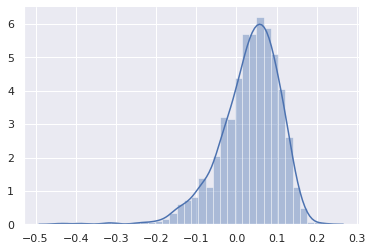

In [4]:

test_r_squared_df=pd.DataFrame(data=test_r_squared)
test_r_squared_df.rename(columns = {0:'coefficient of determination'}, inplace = True) 

sb.distplot(test_r_squared_df)
sb.despine()

In [5]:
#One sample t-test to show the significance.
from scipy.stats import ttest_1samp

tset, pval = ttest_1samp(test_r_squared, 0)
print(pval)


[2.78599797e-41]


In [6]:
sum_ranks, pval_w = wilcoxon(test_r_squared[:,0])
print(pval_w)

3.972274337131865e-48


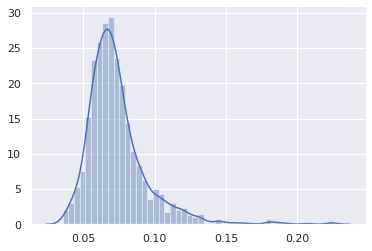

In [7]:
lasso_alpha_df = pd.DataFrame(data=lasso_alpha)
lasso_coef_df = pd.DataFrame(data=lasso_coef)

sb.distplot(lasso_alpha_df)
sb.despine()

In [8]:
mean_coef=lasso_coef_df.mean()


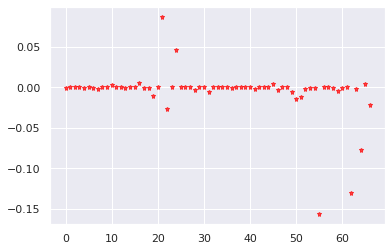

In [9]:

plt.plot(mean_coef,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 0.05$',zorder=7) 

In [12]:
feature_set.to_pickle("./feature_set.pkl")

lasso_r_squared_1000 = pd.DataFrame(data=test_r_squared)
lasso_alpha_1000 = pd.DataFrame(data=lasso_alpha)
lasso_coef_1000 = pd.DataFrame(data=lasso_coef)

lasso_r_squared_1000.to_pickle("./lasso_r_squared_1000.pkl")
lasso_alpha_1000.to_pickle("./lasso_alpha_1000.pkl")
lasso_coef_1000.to_pickle("./lasso_coef_1000.pkl")



In [10]:
feature_set = pd.read_pickle("./feature_set.pkl")

lasso_r_squared_df = pd.read_pickle("./lasso_r_squared_1000.pkl")
lasso_alpha_df = pd.read_pickle("./lasso_alpha_1000.pkl")
lasso_coef_df = pd.read_pickle("./lasso_coef_1000.pkl")



In [11]:
abs_mean_coef=abs(mean_coef)

In [13]:
top_coef=abs_mean_coef.sort_values(ascending=False)
top_coef.head()

55    0.156749
62    0.130742
21    0.087162
64    0.076649
24    0.045673
dtype: float64

In [15]:
all_features = pd.concat([feature_set,location_pay,location_sd], axis = 1)


In [18]:
#Choose the features with top n coefficients 

features_number = 3
#get the top n features and construct a new feature.
top_coef=abs_mean_coef.sort_values(ascending=False)

selected_features = all_features.iloc[:,top_coef.index[0]]

for features in range(features_number-1):
    selected_features = pd.concat([selected_features, all_features.iloc[:,top_coef.index[features+1]]], axis = 1)



In [19]:
selected_features.head()

,55,1,21
0,0.467229,-1.180298,1.103600
1,-1.504403,-1.045167,-0.092121
2,0.888779,0.775737,-0.562840
3,-0.026882,-0.108571,-0.092121
4,0.679443,-0.224316,-1.280074


In [20]:
poly = pp.PolynomialFeatures(interaction_only=True,include_bias = False)
selected_features_interaction=poly.fit_transform(selected_features)
selected_features_interaction=pd.DataFrame(data=selected_features_interaction)
selected_features_interaction.head()

,0,1,2,3,4,5
0,0.467229,-1.180298,1.103600,-0.551469,0.515634,-1.302577
1,-1.504403,-1.045167,-0.092121,1.572352,0.138588,0.096282
2,0.888779,0.775737,-0.562840,0.689458,-0.500240,-0.436616
3,-0.026882,-0.108571,-0.092121,0.002919,0.002476,0.010002
4,0.679443,-0.224316,-1.280074,-0.152410,-0.869737,0.287141


In [21]:
poly.get_feature_names()



['x0', 'x1', 'x2', 'x0 x1', 'x0 x2', 'x1 x2']

In [22]:
#make a model with interactions.
#Run N times and take the average.
#Try to use the shuffle split function => later
x_linear = selected_features_interaction
y_linear = turnOverRate #Turn over

train_number = 1000
#Run this part for 1000 times and get the values for r-squared, alpha, and the weights.
#reg.alpha_, reg.coef_, r2score.

#initialize
linear_r_squared = np.zeros((train_number,1))
linear_coef = np.zeros((train_number,x_linear.shape[1]))

for trialNo in range(train_number):
    
    #split 80-20
    Xl_train, Xl_test, Yl_train, Yl_test = train_test_split(x_linear, y_linear, test_size=0.2)
    

    linear_reg = linear_model.LinearRegression()
    linear_reg.fit(Xl_train,Yl_train)
    
    
    Ypredl = linear_reg.predict(Xl_test)
    
    linear_r_squared[trialNo] = r2_score(Yl_test, Ypredl)
    linear_coef[trialNo,:] = linear_reg.coef_

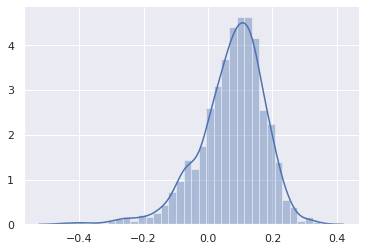

In [23]:
linear_r_squared_df=pd.DataFrame(data=linear_r_squared)
#linear_r_squared_df.hist()
sb.distplot(linear_r_squared_df)
sb.despine()

In [24]:
sum_ranks, pval_w = wilcoxon(linear_r_squared[:,0])
print(pval_w)

4.796393233843468e-84


In [34]:
mean_linear_coef[5]

-0.04878797821166539

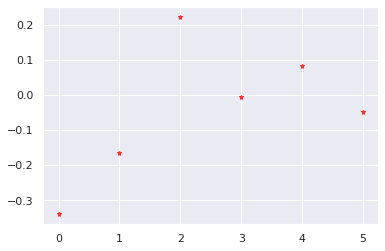

In [25]:
linear_coef_df = pd.DataFrame(data=linear_coef)

mean_linear_coef=linear_coef_df.mean()

plt.plot(mean_linear_coef,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 0.05$',zorder=7) 


In [26]:
#From Fabian Pedregosa-Izquierdo, f@bianp.net
import numpy as np
from scipy import stats, linalg

def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

turnOver_features = pd.concat([turnOverRate, selected_features], axis = 1)
partial_corr_array = turnOver_features.to_numpy()

# Calculate the partial correlation coefficients
partial_corr_results = partial_corr(partial_corr_array)

In [27]:
partial_corr_results_df = pd.DataFrame(data=partial_corr_results)
partial_corr_results_df.head()

,0,1,2,3
0,1.000000,-0.285774,-0.180665,0.209384
1,-0.285774,1.000000,0.116342,0.644236
2,-0.180665,0.116342,1.000000,-0.175639
3,0.209384,0.644236,-0.175639,1.000000


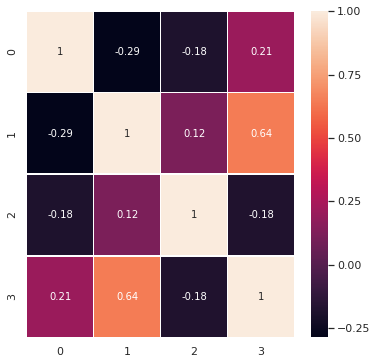

In [28]:
f, ax = plt.subplots(figsize=(6, 6))
sb.heatmap(partial_corr_results, annot=True, linewidths=.5, ax=ax)

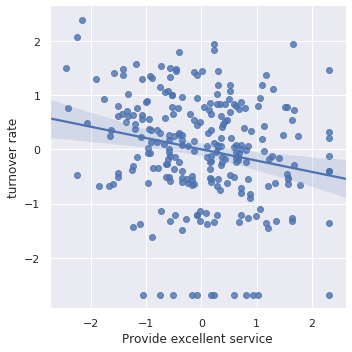

In [29]:

#Put together into a single data frame so we can plot easier
frameMVP = { 'turnover rate': turnOverRate, 'Provide excellent service': all_features.iloc[:,55]} 
dataForPlotMVP = pd.DataFrame(frameMVP)
# Recommended way
sb.lmplot(x='Provide excellent service', y='turnover rate', data=dataForPlotMVP)


